# Assignment 2

Продемонстрировать положение No Free Lunch Theorem. (см материалы семинара)   
Качество работы оценивается по accuracy на тестовой выборке согласно пайплайну (см материалы семинара). Метод валидации (если вы его применяете) 5-fold cv.  
В выводе для каждой модели указать какие предположения она делает относительно данных. В выводе указать почему модель плохо / хорошо работает на сгенерированной вами выборке. Использовать пространство признаков размерности 2 при классификации и размерности 1 при регрессии. При возможности, нарисовать выборку на графике (цветами обозначить классы).  


1. Сгенерировать датасет для задачи бинарной классификации (binary crossentropy), 
на котором метод ближайших соседей работает хуже, чем логистическая регрессия. 

2. Сгенерировать датасет для задачи бинарной классификации (binary crossentropy), 
на котором логистическая регрессия работает хуже, чем метод ближайших соседей.

3. Сгенерировать датасет для задачи бинарной классификации (binary crossentropy), 
на котором метод ближайших соседей с косинусной метрикой расстояния работает лучше, чем с евклидовой метрикой.

4. Сгенерировать датасет для задачи регрессии (MSE),
на котором решающее дерево работает хуже, чем линейная регрессия. 


In [69]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold

In [158]:
def linear(x, k, b, noise=0):
    return (k * x + b) + np.random.normal(scale=noise)


def blob(center, size=5, y_dev=0.5, v_dev=0.5, h_dev=0.5):
    center_x, center_y = center
    
    for _ in range(size):
        yield [center_x + np.random.uniform(high=h_dev),
               center_y + np.random.uniform(high=v_dev) + np.random.uniform(high=y_dev) 
              ]

        
def generate_linear_regression(x_grid=None, noise=0, k=1, b=0):
    y_grid = [linear(x, k, b, noise) for x in x_grid]
    return np.array(x_grid).reshape(-1, 1), np.array(y_grid)


def generate_linear_classification(x_grid=None, noise=0, k1=1, b1=0, k2=1, b2=1):
    x_grid = np.array(x_grid)
    
    X_pos = np.hstack([x_grid.reshape(-1, 1),
                       np.array([linear(x, k1, b1, noise) for x in x_grid]).reshape(-1, 1)
                      ])
    
    X_neg = np.hstack([x_grid.reshape(-1, 1),
                       np.array([linear(x, k2, b2, noise) for x in x_grid]).reshape(-1, 1)
                      ])
    
    X = np.vstack([X_pos, X_neg])
    Y = np.vstack([np.ones(shape=[len(x_grid),]), np.zeros(shape=[len(x_grid),])]).ravel()
    return X, Y 


def generate_blobs_classification(centers, labels, size=10, y_dev=0.5, v_dev=0.5, h_dev=0.5):
    X = list()
    Y = list()
    
    for center, label in zip(centers, labels):
        for sample in blob(center, size, y_dev, v_dev, h_dev):
            X.append(sample)
        Y.extend([label] * size)
    
    return np.array(X), np.array(Y)


def run_experiment(models, dataset_generator, dataset_generator_params, metric, n_folds=5, shuffle=True, test_size=0.3):
    scores = dict()
    X, Y = dataset_generator(**dataset_generator_params)
    METRIC_MAP = {'accuracy': accuracy_score, 'neg_mean_squared_error': mean_squared_error}
    
    if n_folds is not None:
        for i, model in enumerate(models):
            model_name = '%s.%s' % (i+1, str(model).split('(')[0])
            scores[model_name] = abs(cross_val_score(model,
                                                     X,
                                                     Y,
                                                     scoring=metric,
                                                     cv=KFold(n_folds, shuffle=shuffle, random_state=17)
                                                    ).mean())
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=17)

        for i, model in enumerate(models):
            model_name = '%s.%s' % (i+1, str(model).split('(')[0])
            model.fit(X_train, y_train)
            scores[model_name] = METRIC_MAP[metric](y_test, model.predict(X_test))
    
    return scores
    

В целом, кратко, положение No Free Lunch Theorem заключается в том, что для каждой модели должны существовать такие данные, на которых эта модель работает плохо (и какая-либо другая модель -- лучше).  
На практике это можно также трактовать следующим образом. Определенным моделям соответствуют определенные классы задач, которые решаются с их помощью хорошо.

1. Сгенерировать датасет для задачи бинарной классификации (binary crossentropy), на котором метод ближайших соседей работает хуже, чем логистическая регрессия

Предположения относительно данных:
- KNN: выполнение гипотезы компактности, то есть близкие с содержательной точки зрения объекты должны располагаться в признаковом пространстве, образуя обособленные множества точек
- LogReg: выборка должна быть линейно разделимой (или близкой к таковой), то есть признаковое пространство можно разделить гиперплоскостью (в нашем случае - линией) так, что объекты разных классов окажутся по ее разные стороны (в идеале)

Данные следует строить так, чтобы они были линейно разделимы (+LogReg) и чтобы евклидово расстояние между объектами разных классов было как можно меньшим (-KNN).

Пример таких данных приведен ниже.  
Видно, что данные могут быть безошибочно разделены линией (следовательно, безошибочно классифицированы лог. регрессией), а для каждого объекта наиболее близким объектом оказывается объект противоположного класса, что заставляет KNN(1) практически гарантировано ошибаться на любом объекте и делает KNN с произовольным числом соседей непригодным, т.к. для любого объекта в число k ближайших соседей войдет, по сути, одинаковое кол-во объектов обоих классов, превращая таким образом классификацию, скорее, в гадание (в предположении, что используется евклидова метрика).

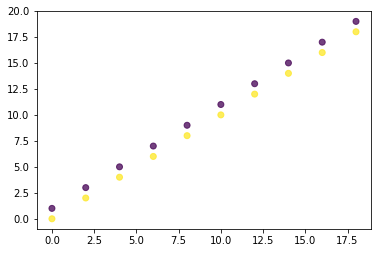

In [77]:
X, Y = generate_linear_classification(range(0, 20, 2), b2=1)
plt.scatter(X[:,0], X[:,1], c=Y, alpha=0.75)

Эксперимент на 10000 объектов

In [75]:
run_experiment([LogisticRegression(), KNeighborsClassifier()],
               generate_linear_classification,
               {'x_grid': range(0, 100000, 10), 'b2': 1},
               'accuracy',
              )

{'1.LogisticRegression': 1.0, '2.KNeighborsClassifier': 0.14694999999999997}

Как видно, классификация с помощью LogReg безошибочна, тогда как KNN много хуже, чем случайное гадание.

Особенно отчетливо предположение иллюстрируется при использовании KNN(1).

In [76]:
run_experiment([LogisticRegression(), KNeighborsClassifier(n_neighbors=1)],
               generate_linear_classification,
               {'x_grid': range(0, 100000, 10), 'b2': 1},
               'accuracy',
              )

{'1.LogisticRegression': 1.0, '2.KNeighborsClassifier': 0.0374}

Как и следовало ожидать, KNN с одним соседом ошибается на таких данных практически всегда (очевидно, не ошибается только тогда, когда самый близкий объект к тестовому попал вместе с ним в тестовый фолд).

 
2 . Сгенерировать датасет для задачи бинарной классификации (binary crossentropy), на котором логистическая регрессия работает хуже, чем метод ближайших соседей.

Исходя из изложенного выше, следует действовать ровно противоположным образом, нежели в предыдущем пункте:  
построим данные так, чтобы объекты одного класса образовывали обособленные облака, удовлетворяя тем самым гипотезе компактности, (+KNN) и эти облака были бы линейно не разделимы между собой (-LogReg).  

Такое расположение объектов приведено ниже, и очевидно, что строящая разделяющую гиперплоскоть лог. регрессия никоим образом не сможет сделать это, избежав ошибок, тогда как условие выполнения гипотезы компактности поможет KNN с евклидовой метрикой и подходящим числом соседей действовать безошибочно.  

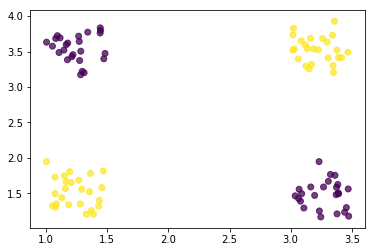

In [82]:
X, Y = generate_blobs_classification([(1, 1), (3, 3), (1, 3), (3, 1)], [1, 1, 0, 0], size=25)
plt.scatter(X[:,0], X[:,1], c=Y, alpha=0.75)

Эксперимент

In [81]:
run_experiment([LogisticRegression(), KNeighborsClassifier()],
               generate_blobs_classification,
               {'centers': [(1, 1), (3, 3), (1, 3), (3, 1)], 'labels': [1, 1, 0, 0], 'size': 10000},
               'accuracy'
              )

{'1.LogisticRegression': 0.5146, '2.KNeighborsClassifier': 1.0}

Как ожидалось, KNN отработал безошибочно, а полученное качество при использовании LogReg закономерно, т.к. наиболее оптимальным решением данной задачи для этой модели является проведение гиперплоскости посередине горизонтально или вертикально, что очевидно ведет к ошибочной классификации половины объектов.

3 . Сгенерировать датасет для задачи бинарной классификации (binary crossentropy), на котором метод ближайших соседей с косинусной метрикой расстояния работает лучше, чем с евклидовой метрикой.

Упомянутое выше условие выполнения гипотезы компактности имеет смысл в контексте евклидовой метрики, однако при использовании косинусной метрики благоприятными оказываются другие условия, а именно, угол между объектами (точнее говоря, между векторами, описывающими их) одного класса должен быть как можно более меньшим вне зависимости от евклидового расстояния между ними.

Однако для вынуждения KNN с евклидовой метрикой работать хуже нам также потребуется строить объекты так, чтобы для каждого из них с точки зрения евклидовой метрики наиболее близким был объект противоположного класса.

Тогда нам в точности подойдут данные из первого пункта. 

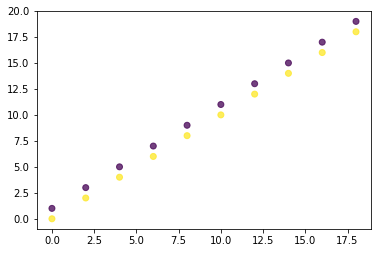

In [88]:
X, Y = generate_linear_classification(range(0, 20, 2), b2=1)
plt.scatter(X[:,0], X[:,1], c=Y, alpha=0.75)

In [87]:
run_experiment([KNeighborsClassifier(metric='cosine'), KNeighborsClassifier()],
               generate_linear_classification,
               {'x_grid': range(0, 100000, 10), 'b2': 1},
               'accuracy',
              )

{'1.KNeighborsClassifier': 0.9999500000000001,
 '2.KNeighborsClassifier': 0.14694999999999997}

*1.KNeighborsClassifier(metric=cosine) : 0.99  
2.KNeighborsClassifier(metric=eucl.) : 0.15*

Результат предсказуем, т.к. при такой конфигурации данных объекты одного класса образуют линию, следовательно, угол между всеми ними равен нулю, следоваельно, значение косинусной метрики минимально, тогда как уже описанное выше поведение евклидовой метрики на подобных данных не позволяет проводить осмысленную классификацию.

4 . Сгенерировать датасет для задачи регрессии (MSE), на котором решающее дерево работает хуже, чем линейная регрессия.

Предположения относительно данных:
- LinReg: зависимость между предикторами и целевой переменной линейна или близка к таковой
- DecisionTree: данные можно разделить сколь угодно сложной разделяющей поверхностью, линии которой всегда параллельны осям координат
    
В подходящих нам данных целевая переменная должна линейно выражаться через единственный признак и свобод. коэф., например, данные могут образовывать линию, находящуюся под углом ко всем осям координат, что позволит линейной регрессии теоретически приблизить зависимость идеально точно или устремить ошибку к бесконечно малому значению, тогда как дерево будет пытаться приблизить зависимость "лестницей" из линий, параллельных осям, однако предсказание с помощью такой "лестницы" всегда будет в определенной степени не точным.

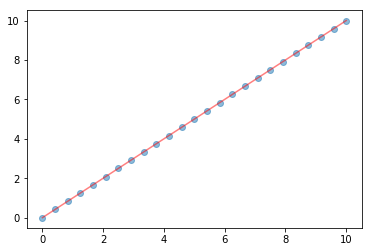

In [89]:
x_grid = np.linspace(0, 10, 25)
X, Y = generate_linear_regression(x_grid)
plt.scatter(X, Y, alpha=0.5)
plt.plot(x_grid, x_grid, color='r', alpha=0.5)

In [163]:
run_experiment([DecisionTreeRegressor(), LinearRegression()],
               generate_linear_regression,
               {'x_grid': np.linspace(0, 100, 10000), 'noise': 0},
               'neg_mean_squared_error',
               shuffle=False
              )

{'1.DecisionTreeRegressor': 73.41803287239414,
 '2.LinearRegression': 3.635071051258422e-29}

Очевидна колоссальная разница в качестве и видна ожидаемая бесконечно малая ошибка линейной регресии и невероятно большая в сравнении с последней ошибка решающего дерева.  
Также стоит отметить, что построенное решающее дерево, вообще говоря, является сильно переобученым, выделяя для каждого объекта отдельный лист. Тем не менее, на таких данных столь глубокое дерево потенциально должно дать наилучший возможный для данной модели результат, бесконечно приближая линию сложной лестницей.  

Более того, решающее дерево работает хуже линейной регрессии и при наличии шума в данных рассматриваемого типа, из чего можно сделать вывод, что наличие линейно подобной зависимости между целевой переменной и предикторами негативно сказывается на качестве работы деревянных моделей. 

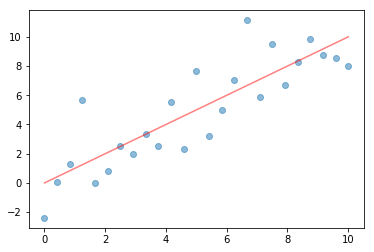

In [166]:
x_grid = np.linspace(0, 10, 25)
X, Y = generate_linear_regression(x_grid, noise=2)
plt.scatter(X, Y, alpha=0.5)
plt.plot(x_grid, x_grid, color='r', alpha=0.5)

In [167]:
run_experiment([DecisionTreeRegressor(), LinearRegression()],
               generate_linear_regression,
               {'x_grid': np.linspace(0, 100, 10000), 'noise': 2},
               'neg_mean_squared_error',
               shuffle=False
              )

{'1.DecisionTreeRegressor': 96.19275489980409,
 '2.LinearRegression': 4.007791181672571}